In [0]:
# !gdown https://drive.google.com/uc?id=1seKxzzId3HpAhbyC9F7zKoUU_sz5MJDN
# !unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
# !tar xvzf fer2013.tar.gz
# !mv fer2013/fer2013.csv .
# !rm -rf fer2013
# !rm -rf sample_data
# !rm -rf fer2013.tar.gz
# !rm -rf challenges-in-representation-learning-facial-expression-recognition-challenge.zip
# !pip install torchvision fastai==0.7
# !pip uninstall torchvision
# !pip uninstall torch
# !pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
# !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.image import imsave
# This file contains all the main external libs
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [107]:
dataset = pd.read_csv('fer2013.csv')
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
# dir_mapping = {
#     'Training': 'train',
#     'PrivateTest': 'train',
#     'PublicTest': 'valid'
# }
# !rm -rf data
# os.mkdir('data')
# os.mkdir('data/train')
# os.mkdir('data/valid')

# for index, series in dataset.iterrows():
#   img = np.array(series['pixels'].split(' '), dtype=np.float).reshape(48, 48)
#   if not os.path.isdir(os.path.join('data', dir_mapping[series['Usage']], str(series['emotion']))):
#     os.mkdir(os.path.join('data', dir_mapping[series['Usage']], str(series['emotion'])))
#   imsave('{0}/{1}_{2}.jpg'.format(os.path.join('data', dir_mapping[series['Usage']], str(series['emotion'])), index, series['emotion']), img)

In [0]:
PATH = "/content/data/"
sz=48

In [110]:
#Check if GPU is available
print (torch.cuda.is_available())
print (torch.backends.cudnn.enabled)

True
True


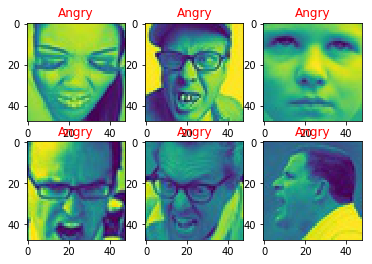

In [111]:
# plot few training images
files = os.listdir(f'{PATH}valid/0')[:6]
emotions = {
    '0': 'Angry',
    '1': 'Disgust',
    '2': 'Fear',
    '3': 'Happy',
    '4': 'Sad',
    '5': 'Surprise',
    '6': 'Neutral'
}

count = 0
for index in range (0, 6):
  plt.subplot(2, 3, count + 1)
  plt.title(emotions[os.path.basename(files[index]).split('.')[0].split('_')[1]], color = 'red')
  plt.imshow(plt.imread(f'{PATH}valid/0/{files[index]}'))
  count += 1
  
plt.show()

In [112]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.metrics = []
learn.fit(0.01, 10)

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


epoch      trn_loss   val_loss   
    0      1.700825   1.596906  
    1      1.657499   1.584172  
    2      1.636415   1.555042  
    3      1.610277   1.552602  
    4      1.578072   1.529515  
    5      1.579289   1.5378    
    6      1.553114   1.513459  
    7      1.542176   1.502685  
    8      1.535896   1.498385  
    9      1.519957   1.491053  


[1.4910525135357555]

In [0]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


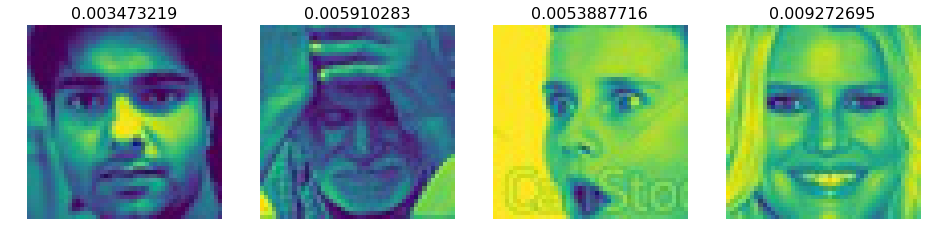

In [117]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


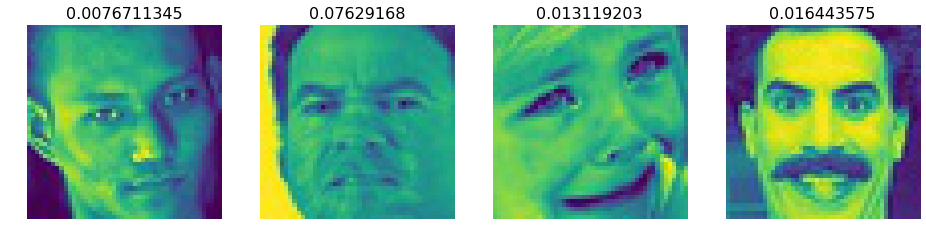

In [118]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

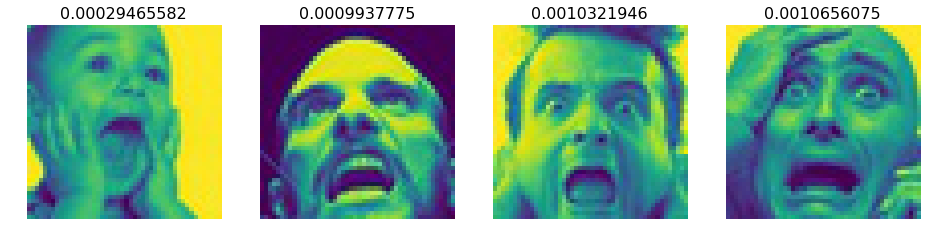

In [120]:
plot_val_with_title(most_by_correct(2, True), "")

Most uncertain predictions


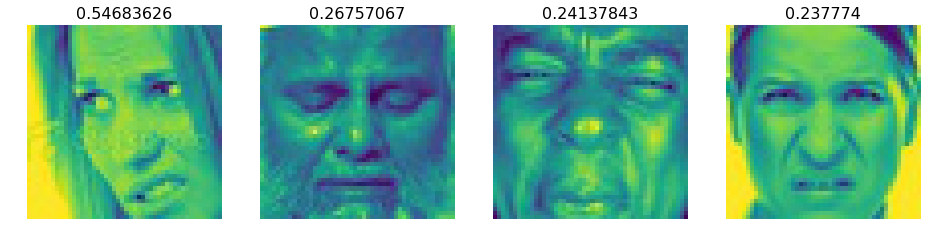

In [121]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [122]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [123]:
learn.metrics = []
lrf=learn.lr_find()

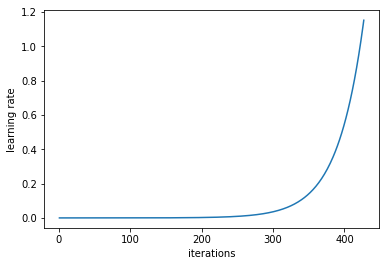

In [124]:
learn.sched.plot_lr()

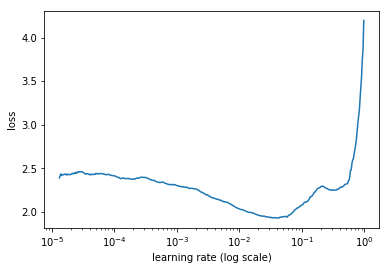

In [125]:
learn.sched.plot()

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

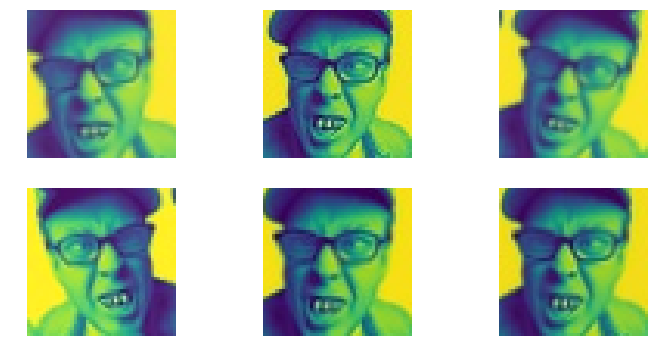

In [129]:
plots(ims, rows=2)

In [130]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

/usr/local/lib/python3.6/dist-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [131]:
learn.metrics = []
learn.fit(0.01, 50)

epoch      trn_loss   val_loss   
    0      1.6989     1.593435  
    1      1.63859    1.571116  
    2      1.626335   1.561839  
    3      1.617377   1.550621  
    4      1.574474   1.521517  
    5      1.569378   1.540501  
    6      1.551514   1.515704  
    7      1.546701   1.506012  
    8      1.523529   1.50323   
    9      1.520933   1.488401  
    10     1.508666   1.488627  
    11     1.493063   1.489536  
    12     1.501042   1.486541  
    13     1.508778   1.471623  
    14     1.480562   1.477669  
    15     1.468857   1.470316  
    16     1.460068   1.468152  
    17     1.453572   1.46473   
    18     1.444479   1.465023  
    19     1.421932   1.457491  
    20     1.414086   1.457127  
    21     1.428143   1.455486  
    22     1.414651   1.451086  
    23     1.401199   1.448445  
    24     1.405349   1.454416  
    25     1.404683   1.449298  
    26     1.395037   1.445366  
    27     1.38308    1.440642  
    28     1.386308   1.437826  
    29   

[1.4231813661100208]

In [0]:
learn.precompute=False

In [133]:
learn.fit(1e-2, 10, cycle_len=1)

epoch      trn_loss   val_loss   
    0      1.491539   1.42902   
    1      1.480681   1.432912  
    2      1.478556   1.430388  
    3      1.499075   1.433812  
    4      1.484064   1.428538  
    5      1.469511   1.429456  
    6      1.485878   1.430082  
    7      1.467552   1.426203  
    8      1.462912   1.431547  
    9      1.45789    1.431472  


[1.4314720895370756]

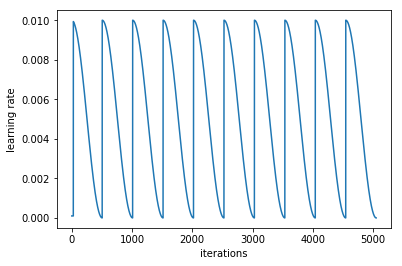

In [134]:
learn.sched.plot_lr()

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([0.01,0.01,0.01])

In [139]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   
    0      1.311933   1.243922  
    1      1.160432   1.146808  
    2      1.07392    1.085498  
    3      1.070471   1.052925  


[1.0529249719870593]

In [140]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print (accuracy_np(probs, y))
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

0.6035107272220674


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[219   2  30  49  80  10  77]
 [ 17  15  10   2   7   0   5]
 [ 57   0 149  24 144  41  81]
 [ 20   0   6 771  23  17  58]
 [ 60   0  45  52 338   7 151]
 [  5   1  39  25  12 308  25]
 [ 37   0  26  60 111   7 366]]


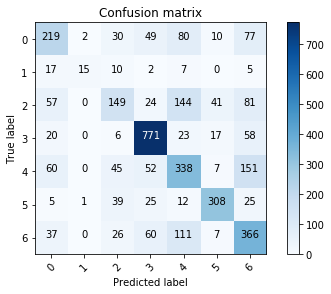

In [142]:
plot_confusion_matrix(cm, data.classes)